In [80]:
from __future__ import absolute_import, division, print_function, unicode_literals
import argparse
import logging
import os
import sys
import io
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
from PIL import Image
import glob
from tensorflow.keras.preprocessing import image

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tensorflow.keras import backend as K
import random
from tensorflow.keras.utils import plot_model
import re
tf.keras.backend.clear_session()
from callbacks import CallBacks
from model_factory import GetModel
from preprocess import Preprocess, format_example, format_example_tf, update_status
#from tf_explain.callbacks.grad_cam import GradCAMCallback
#from tf_explain.core.grad_cam import GradCAM
from pathlib import Path


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import cv2

In [81]:
filepath='/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/bw.nobg.1024.cnv_exprs_allgenes_log_bilinear_topvar_segment/VGG16_Nadam_1e-05-BinaryCrossentropy/my_model.h5'
#new_model = models.load_model(filepath)

'''Loadmodel'''
#new_model = models.load_model(model_path)
checkpoint_dir=os.path.dirname(filepath)
model_name=os.path.basename(os.path.dirname(filepath))
model_type = model_name.split("_")[0]
optimizer = model_name.split("_")[1]
loss_function = model_name.split("-")[-1]
lr = float(model_name.split("_")[-1].replace(loss_function,"")[:-1])
#print(model_type,optimizer,loss_function,lr)
#sys.exit(0)
'''Loadmodel'''
#new_model = models.load_model(model_path)
m = GetModel(model_name=model_type, img_size=256, classes=2, num_layers=None, reg_drop_out_per=None, l2_reg=None)
new_model = m.compile_model(optimizer, lr, loss_function)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
new_model.load_weights(latest)


#print(new_model.summary())

#plot_model(new_model, show_shapes=True, to_file='model.png')
#sys.exit(0)
IMAGE_SHAPE = (256, 256)

#input_folder="/projects/shart/digital_pathology/scripts/Breast_CHEK2/General-ImageClassifier_pipeline_scripts/sample_patch"
#output_folder="/projects/shart/digital_pathology/scripts/Breast_CHEK2/General-ImageClassifier_pipeline_scripts/sample_patch_cam"
#input_folder="/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam/input"
#output_folder="/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam/output"
input_folder="/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam/input_cnv_segment"
output_folder="/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam/output_segment"

files=os.listdir(input_folder)
#layer_name="conv5_block3_3_conv"
layer_name="block4_conv3"    

Model loaded was VGG16
/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/bw.nobg.1024.cnv_exprs_allgenes_log_bilinear_topvar_segment/VGG16_Nadam_1e-05-BinaryCrossentropy/cp-0037.ckpt


In [82]:
files[:2]

['TCGA-18-3407-01.png', 'TCGA-21-5786-01.png']

PIL.PngImagePlugin (DEBUG): STREAM b'IHDR' 16 13
PIL.PngImagePlugin (DEBUG): STREAM b'PLTE' 41 768
PIL.PngImagePlugin (DEBUG): STREAM b'IDAT' 821 8192


TCGA-18-3407-01.png


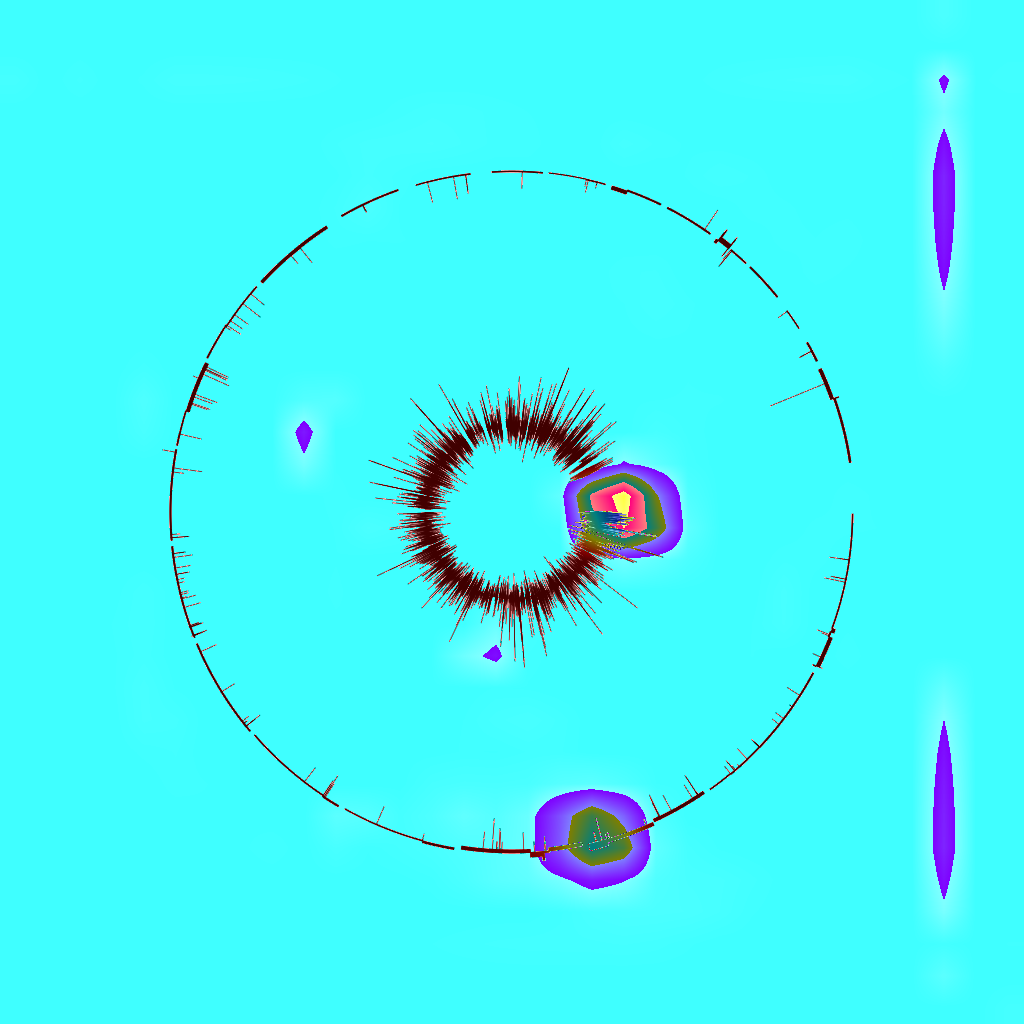

In [83]:
imgpath=files[0]
#for imgpath in files:
print(imgpath)
orig=os.path.join(input_folder,imgpath)
imgpath=imgpath.replace('.png','_out.png')
###example start

#print(new_model.summary())
###example end
class_index=0
#orig=imgpath
intensity=0.5 
res=250
img = image.load_img(orig, target_size=IMAGE_SHAPE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

b = K.constant(x)
#b = tf.io.decode_png(b, channels=3)
b = tf.cast(b, tf.float32)/255
#b = tf.image.per_image_standardization(b)
b = tf.image.resize(b, IMAGE_SHAPE)
b = tf.image.rgb_to_hsv(b)
b = tf.reshape(b, (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3))
x=K.eval(b)
x = np.expand_dims(x, axis=0) 
#print(x.shape)
#sys.exit(0)    
preds = new_model.predict(x)
preds_str=str(round(preds[0][0],2))+'_'+str(round(preds[0][1],2))
imgpath=imgpath.replace('_out.png','_'+preds_str+'_out.png')
#print(imgpath)
#sys.exit(0)
with tf.GradientTape() as tape:
    last_conv_layer = new_model.get_layer(layer_name)
    iterate = tf.keras.models.Model([new_model.inputs], [new_model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
heatmap = np.maximum(heatmap, 0)
if np.max(heatmap)>0.:
    heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((32, 32))    
img = cv2.imread(orig)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap1 = heatmap.copy()
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
img = heatmap * intensity + img
img1 = heatmap * intensity
#cv2.imwrite(os.path.join(output_folder,imgpath), cv2.resize(img, IMAGE_SHAPE))
#cv2.imwrite(os.path.join(output_folder,imgpath), img)
#cv2.imwrite(os.path.join(output_folder,imgpath+'_heatmap.png'), img1)
Image.fromarray(img.astype(np.uint8))

In [16]:
heatmap.shape,img.shape

((1024, 1024), (1024, 1024, 3))

In [25]:
heatmap1.shape,heatmap1[0,0]

((1024, 1024), 0.0)

In [29]:
#heatmap.flatten()

In [28]:
#plt.hist(list(heatmap.flatten()), bins='auto')
#plt.show()

In [51]:
from skimage import measure
import numpy as np
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

# Set the threshold value
threshold = 0.5
# Find the contours in the image
contours = measure.find_contours(heatmap1, threshold)
# Create a list of Polygon objects from the contours
polygons = [Polygon(contour) for contour in contours]
# Create a MultiPolygon object from the list of Polygon objects
multipolygon = MultiPolygon(polygons)
print(len(multipolygon))

2


In [64]:
list(multipolygon[0].bounds)

[476.941958168573, 582.5447946108316, 543.0398521502901, 657.2514534584276]

In [78]:
list(multipolygon[1].bounds)

[814.3685257070099, 578.5548881741979, 856.9485468281209, 621.7256989090523]

In [76]:
#from matplotlib import pyplot as plt
#from matplotlib import draw_multipolygon
# Load the image and convert it to RGB
##image = plt.imread(orig)
#image = image[:, :, :3]

# Overlay the polygons on the image
#fig, ax = plt.subplots()
#ax.imshow(image)
#ax.set_aspect('equal')
#draw_multipolygons(ax, multipolygon, facecolor='none', edgecolor='red')

#plt.show()

In [69]:
orig

'/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam/input_cnv_segment/TCGA-18-3407-01.png'

PIL.PngImagePlugin (DEBUG): STREAM b'IHDR' 16 13
PIL.PngImagePlugin (DEBUG): STREAM b'PLTE' 41 768
PIL.PngImagePlugin (DEBUG): STREAM b'IDAT' 821 8192


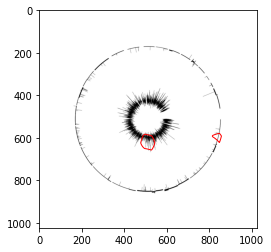

In [72]:
from matplotlib import pyplot as plt
from descartes import PolygonPatch

# Load the image and convert it to RGB
image = plt.imread(orig)
image = image[:, :, :3]

# Overlay the polygons on the image
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_aspect('equal')
for polygon in multipolygon:
    patch = PolygonPatch(polygon, facecolor='none', edgecolor='red')
    ax.add_patch(patch)

plt.show()


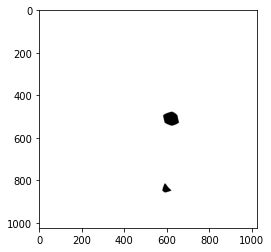

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [75]:
import cv2
import matplotlib.pyplot as plt

# read the image
image = cv2.imread(orig)
# convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# convert to grayscale
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# create a binary thresholded image
_, binary = cv2.threshold(heatmap1, 0.5, 1, cv2.THRESH_BINARY_INV)
# show it
plt.imshow(binary, cmap="gray")
plt.show()
# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
# show the image with the drawn contours
plt.imshow(image)
plt.show()

In [77]:
contours

[array([[543.03985215, 624.        ],
        [543.03592692, 623.        ],
        [543.        , 622.86486474],
        [542.76725563, 622.        ],
        [542.49193451, 621.        ],
        [542.20970675, 620.        ],
        [542.        , 619.27284206],
        [541.9203156 , 619.        ],
        [541.62348015, 618.        ],
        [541.31891302, 617.        ],
        [541.00630556, 616.        ],
        [541.        , 615.98009706],
        [540.68533735, 615.        ],
        [540.35566564, 614.        ],
        [540.016933  , 613.        ],
        [540.        , 612.95072159],
        [539.66876207, 612.        ],
        [539.31075187, 611.        ],
        [539.        , 610.15433405],
        [538.94247482, 610.        ],
        [538.56349036, 609.        ],
        [538.17331943, 608.        ],
        [538.        , 607.5650542 ],
        [537.77146195, 607.        ],
        [537.35738454, 606.        ],
        [537.        , 605.16068922],
        [536

In [84]:
!pwd

/research/bsi/projects/pharmacogenetics/s112047.beauty/analyses/manuscripts/Naresh_ML_DP_2_2_2021/code/General-ImageClassifier_hsv_bilinear
